# Moving average method

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('/content/Time Series COVID-19 Confirmed Global - Regression Task - Data.csv')
dfz = pd.read_json (r'/content/timeline.json')


FileNotFoundError: [Errno 2] File /content/Time Series COVID-19 Confirmed Global - Regression Task - Data.csv does not exist: '/content/Time Series COVID-19 Confirmed Global - Regression Task - Data.csv'

## Data Preparation

กำหนด ให้ train เป็นจำนวนผู้ป่วยสะสมของไทย

In [0]:
train = df[df['Country/Region'] == "Thailand"]
train = train.groupby(['Country/Region']).sum()

In [0]:
train = train.drop(['Lat','Long'],axis=1)


In [0]:
train

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Thailand,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82,114,147,177,212,272,322,411,599,721,827,934,1045,1136


In [0]:
train = train.T
train.tail(5)

Country/Region,Thailand
3/23/20,721
3/24/20,827
3/25/20,934
3/26/20,1045
3/27/20,1136


กำหนดค่า test โดยใช้ข้อมูลจาก 'timeline.json'

In [0]:
#add date
check = 0
lst = []
date = []
for i in dfz['Data']:
  if i['Date'] == '03/27/2020':
    check = 1
  elif check == 1:
    #เปลี่ยนให้ ค.ศ จาก 2020 ให้เป็น 20
    date.append(i['Date'][:len(i)-1])
    lst.append(i['NewConfirmed'])
y_test = pd.DataFrame({'Confirmed':lst},index=date)

In [0]:
y_test.head(5)

,Confirmed
03/28/20,109
03/29/20,143
03/30/20,136
03/31/20,127
04/01/20,120


ทำการเปลี่ยนข้อมูลเป็นยอดสะสมของผู้ป่วย

In [0]:
start = train.Thailand.max()
lstz = []
for i in y_test['Confirmed']:
  start += i
  lstz.append(start)
y_test['Thailand'] = lstz
y_test = y_test.drop(['Confirmed'],axis=1)

In [0]:
y_test.head(5)

,Thailand
03/28/20,1245
03/29/20,1388
03/30/20,1524
03/31/20,1651
04/01/20,1771


## Data Modeling

### Weighted Moving Average

กำหนดน้ำหนัก เท่ากับ (1-14)**16 โดยค่าน้ำหนักที่เราใช้ได้จากการสุ่ม

In [0]:
weights_profit = np.arange(1,15)**16
weights_profit

array([                  1,               65536,            43046721,
                4294967296,        152587890625,       2821109907456,
            33232930569601,     281474976710656,    1853020188851841,
         10000000000000000,   45949729863572161,  184884258895036416,
        665416609183179841, 2177953337809371136])

ทำการ Predict ข้อมูลโดยใช้ Moving Average

In [0]:
history = train.values
#history = np.append(history,1245)
test = y_test.values
window = 14
predictions = []
#นำข้อมูลหารด้วย 1 แสนเนื่องจากปัญหาการที่ตัวเลขมากเกินไปทำให้ค่าผิดเพี้ยน
weights_profit = (weights_profit/100000).reshape(14,)
for t in range(len(test)):
  obs = test[t]
  history = np.append(history,obs)
  x = (history[::-1][:14][::-1]/100000).reshape(14,)
  length = len(history)
  yhat = np.dot(x, weights_profit)/weights_profit.sum()
  yhat = yhat*100000
  predictions.append(yhat)
  print('predicted=%f, expected=%f' % (yhat, obs))

predicted=1203.151251, expected=1245.000000
predicted=1335.089185, expected=1388.000000
predicted=1470.209770, expected=1524.000000
predicted=1599.712325, expected=1651.000000
predicted=1722.468363, expected=1771.000000
predicted=1831.900381, expected=1875.000000
predicted=1936.623009, expected=1978.000000
predicted=2030.157942, expected=2067.000000
predicted=2129.521725, expected=2169.000000
predicted=2194.788813, expected=2220.000000
predicted=2240.443449, expected=2258.000000
predicted=2331.899982, expected=2369.000000
predicted=2397.367564, expected=2423.000000
predicted=2451.744048, expected=2473.000000
predicted=2499.330423, expected=2518.000000
predicted=2536.506769, expected=2551.000000
predicted=2567.065956, expected=2579.000000
predicted=2599.947164, expected=2613.000000
predicted=2630.798091, expected=2643.000000
predicted=2660.323144, expected=2672.000000
predicted=2688.752694, expected=2700.000000
predicted=2720.390810, expected=2733.000000
predicted=2752.316510, expected=

#### Evaluation

In [0]:
from sklearn.metrics import mean_absolute_error
MSE = (1/len(predictions))*(np.sum((history[::-1][:len(predictions)][::-1]-predictions)**2))
rmse = MSE**(1/2)
MAE = mean_absolute_error(history[::-1][:len(predictions)][::-1],predictions)

print('Mean Square Error = %.3f' %MSE)
print('Root Mean Square Error = %.3f' %rmse)
print('Mean Absolure Error= %.3f' %MAE)

Mean Square Error = 667.427
Root Mean Square Error = 25.835
Mean Absolure Error= 19.977


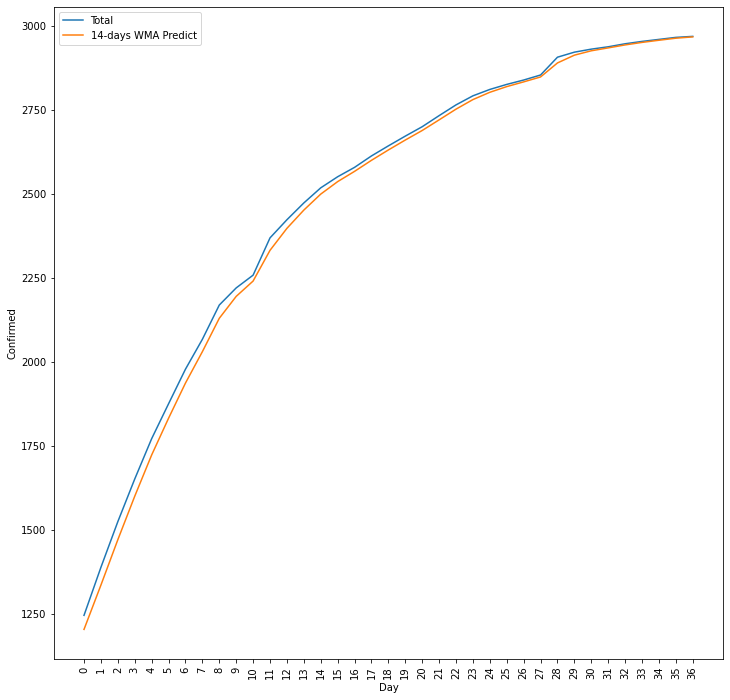

In [0]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize = (12,12))
x = np.arange(0,len(test),1)
plt.plot(test, label="Total")
plt.plot(predictions, label="14-days WMA Predict")
plt.xticks(x,rotation='vertical')
plt.xlabel('Day')
plt.ylabel("Confirmed")
plt.legend()
plt.show()

### Exponential Weighted Moving average

ทำการนำข้อมูลวันที่ทั้ง train และ test มารวมกันเพื่อเตรียม plot กราฟ

In [0]:
train = pd.concat([train,pd.DataFrame({'Thailand':y_test.Thailand},index = date)])

In [0]:
train

Country/Region,Thailand
1/22/20,2
1/23/20,3
1/24/20,5
1/25/20,7
1/26/20,8
...,...
04/29/20,2947
04/30/20,2954
05/01/20,2960
05/02/20,2966


ทำการสร้าง DataFrame testplot สำหรับนำข้อมูลที่ predict มาเทียบกับข้อมูลจริง

In [0]:
testplot = pd.concat([pd.DataFrame({'Thailand':[np.nan for i in range(len(train))]},index = train.index),
                      pd.DataFrame({'Thailand':predictions},index = date)])

ทำการทำนายโดยใช้ Exponential weighted moving average

ใน Pandas มีฟังก์ชั่นสำหรับการทำ [EWM](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html) อยู่แล้ว จึงใช้ฟังก์ชั่นของ pandas ในการคำนวณ

In [0]:
ewm = train.Thailand.ewm(alpha=0.8).mean()

#### Evaluation

In [0]:
from sklearn.metrics import mean_absolute_error
MSE = (1/len(ewm))*(np.sum(train.Thailand-ewm)**2)
rmse = MSE**(1/2)
MAE = mean_absolute_error(train.Thailand,ewm)

print('Mean Square Error = %.3f' %MSE)
print('Root Mean Square Error = %.3f' %rmse)
print('Mean Absolure Error= %.3f' %MAE)

Mean Square Error = 5337.515
Root Mean Square Error = 73.058
Mean Absolure Error= 7.199


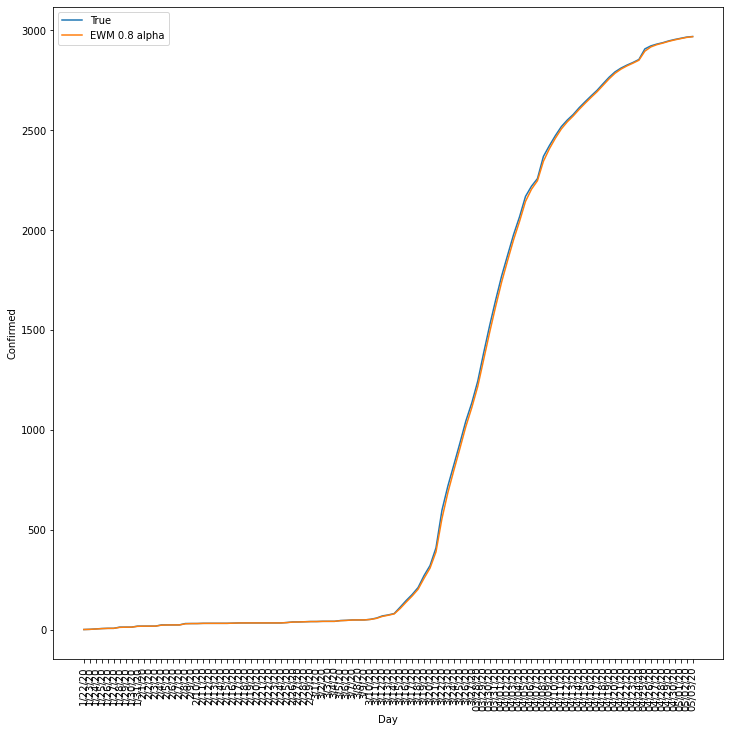

In [0]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize = (12,12))
x = np.arange(0,len(train),1)
plt.plot(train.Thailand, label="True")
plt.plot(ewm, label="EWM 0.8 alpha")
plt.xticks(x,rotation='vertical')
plt.xlabel("Day")
plt.ylabel("Confirmed")
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import mean_absolute_error
MSE = (1/len(predictions))*(np.sum((history[::-1][:len(predictions)][::-1]-predictions)**2))
rmse = MSE**(1/2)
MAE = mean_absolute_error(history[::-1][:len(predictions)][::-1],predictions)

print('Mean Square Error = %.3f' %MSE)
print('Root Mean Square Error = %.3f' %rmse)
print('Mean Absolure Error= %.3f' %MAE)

Mean Square Error = 667.427
Root Mean Square Error = 25.835
Mean Absolure Error= 19.977


# Polynomial Regression

In [0]:
import pandas as pd

In [0]:
df = pd.read_csv('/content/Time Series COVID-19 Confirmed Global - Regression Task - Data.csv')
dfz = pd.read_json (r'/content/timeline.json')


## Data Preparation

In [0]:
train = df[df['Country/Region'] == "Thailand"]
train = train.groupby(['Country/Region']).sum()
train = train.drop(['Lat','Long'],axis=1)
train = train.T
train.tail(5)

Country/Region,Thailand
3/23/20,721
3/24/20,827
3/25/20,934
3/26/20,1045
3/27/20,1136


In [0]:
train['day'] = [i for i in range(1,len(train)+1)]

In [0]:
train

Country/Region,Thailand,day
1/22/20,2,1
1/23/20,3,2
1/24/20,5,3
1/25/20,7,4
1/26/20,8,5
...,...,...
3/23/20,721,62
3/24/20,827,63
3/25/20,934,64
3/26/20,1045,65


In [0]:
#add date
check = 0
lst = []
date = []
for i in dfz['Data']:
  if i['Date'] == '03/27/2020':
    check = 1
  elif check == 1:
    #เปลี่ยนให้ ค.ศ จาก 2020 ให้เป็น 20
    date.append(i['Date'][:len(i)-1])
    lst.append(i['NewConfirmed'])
y_test = pd.DataFrame({'Confirmed':lst},index=date)

In [0]:
start = train.Thailand.max()
lstz = []
for i in y_test['Confirmed']:
  start += i
  lstz.append(start)
y_test['Thailand'] = lstz
y_test = y_test.drop(['Confirmed'],axis=1)

In [0]:
y_test['day'] = [i+66 for i in range(1,len(y_test)+1)]

In [0]:
y_test.head(5)

,Thailand,day
03/28/20,1245,67
03/29/20,1388,68
03/30/20,1524,69
03/31/20,1651,70
04/01/20,1771,71


In [0]:
 data = pd.concat([train,y_test])

ทำการ plot เพื่อดูลักษณะของกราฟ ทุก ๆ 14 วัน

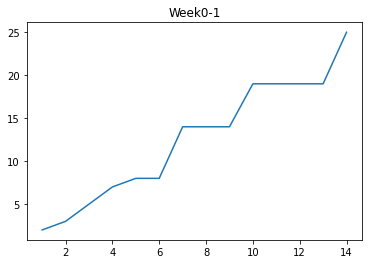

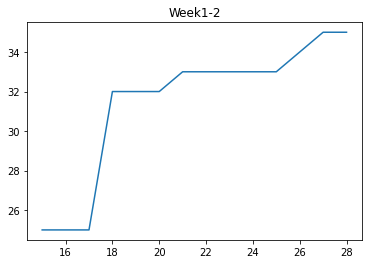

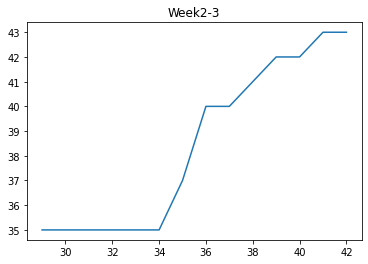

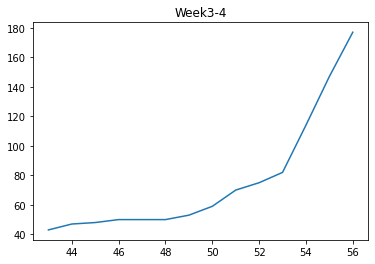

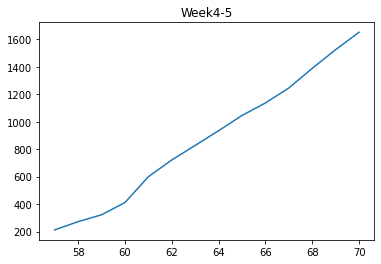

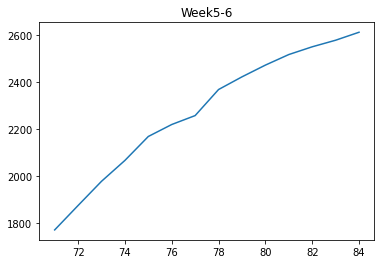

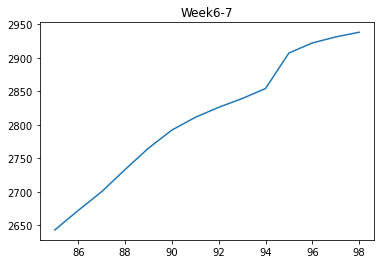

In [0]:
for i in range(len(data)//14):
  j = i+1
  dataz = data.iloc[i*14:j*14,:]
  plt.plot(dataz.day,dataz.Thailand)
  plt.title('Week'+str(i)+'-'+str(j))
  plt.show()

ลักษณะของข้อมูลทั้งหมด

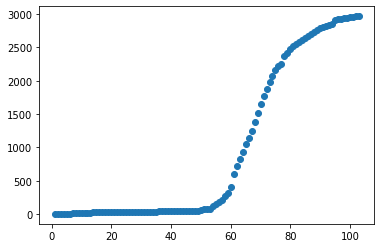

In [0]:
plt.scatter(data.day,data.Thailand)
plt.show()

In [0]:
X = data.day.to_numpy().reshape(-1,1)
y = data.Thailand.to_numpy().reshape(-1,1)

แบ่ง Train,Test โดยให้ test_size = 20%

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=False)

## Data Modeling

จากกราฟจะเห็นได้ว่าลักษณะของกราฟมีลักษะไม่เป็นเส้นตรง จึงต้องทำข้อมูลให้เป็น Polynomial เพื่อให้การทำนายเข้ารูปกับข้อมูล ทำการ train โมเดลโดยใช้ degree ตั้งแต่ 1-14 แล้วทำการเลืออกจำนวน degree ที่เหมาะสมที่สุด

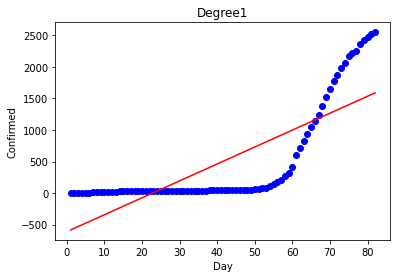

MSE = 245388.257


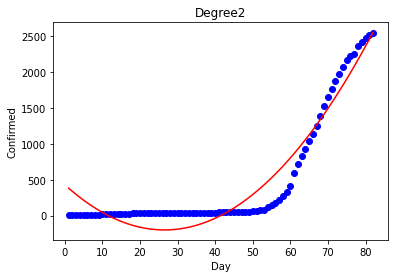

MSE = 44443.180


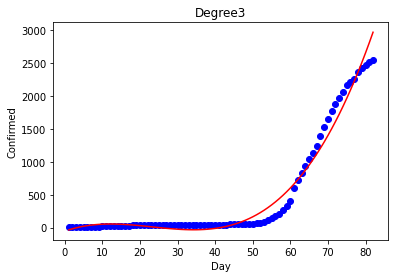

MSE = 15615.181


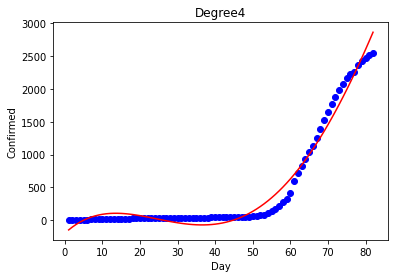

MSE = 13865.660


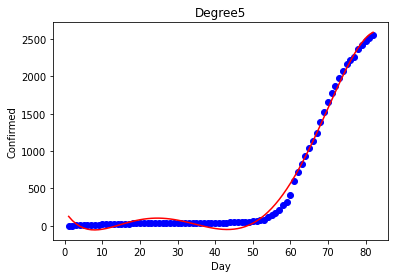

MSE = 4170.606


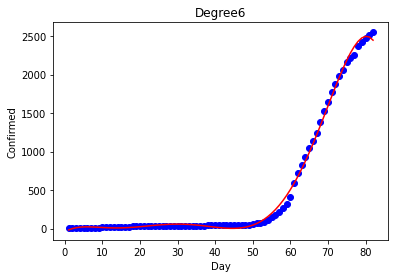

MSE = 1584.526


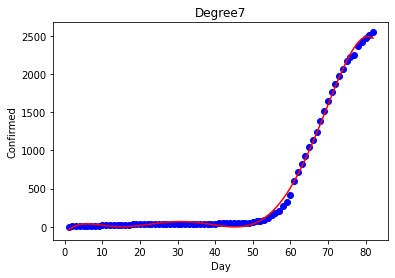

MSE = 1500.632


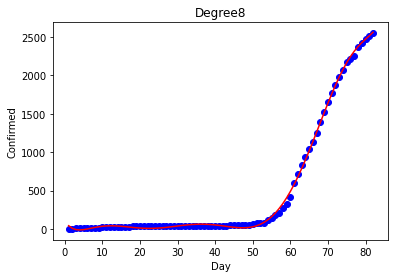

MSE = 633.240


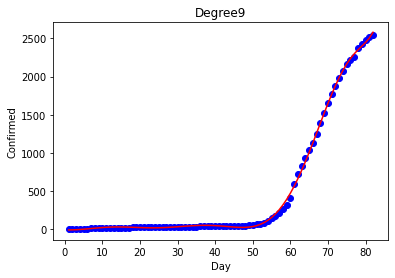

MSE = 446.962


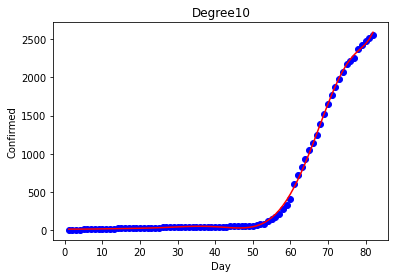

MSE = 490.480


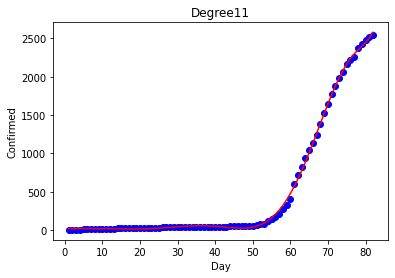

MSE = 502.235


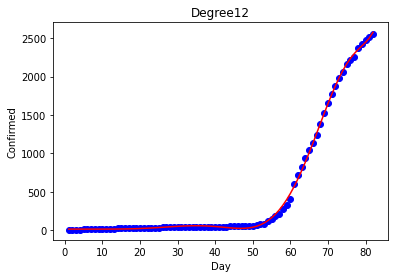

MSE = 499.874


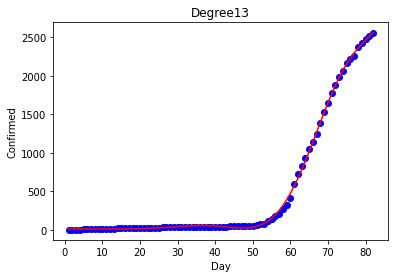

MSE = 413.537


In [0]:
# Fitting Polynomial Regression to the dataset 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures 
for i in range(1,14):
  poly = PolynomialFeatures(degree = i) 
  X_poly = poly.fit_transform(X_train) 
    
  poly.fit(X_poly, y_train) 
  lin2 = LinearRegression() 
  lin2.fit(X_poly, y_train) 
  plt.scatter(X_train, y_train, color = 'blue') 
  mse = (np.square(y_train - lin2.predict(poly.fit_transform(X_train)))).mean()
  plt.plot(X_train, lin2.predict(poly.fit_transform(X_train)), color = 'red') 
  plt.title('Degree'+str(i)) 
  plt.xlabel('Day') 
  plt.ylabel('Confirmed') 
    
  plt.show()
  print('MSE = %.3f' %mse)

Degree = 8

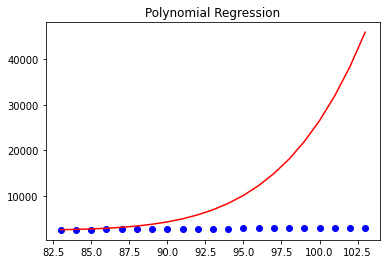

In [0]:
poly = PolynomialFeatures(degree = 8) 
X_poly = poly.fit_transform(X_train) 
  

lin2 = LinearRegression() 
lin2.fit(X_poly, y_train)

plt.scatter(X_test, y_test, color = 'blue') 
  
plt.plot(X_test, lin2.predict(poly.fit_transform(X_test)), color = 'red') 
plt.title('Polynomial Regression')  
  
plt.show() 


In [0]:
from sklearn.metrics import mean_absolute_error
print('MAE = %.3f' %mean_absolute_error(lin2.predict(poly.fit_transform(X_test)),y_test))


MAE = 10146.464
